In [1]:
import sys; print(sys.executable)
%pip install -U lightgbm
%pip install -q tqdm

from tqdm.auto import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from scipy.stats import norm   # <-- this fixes NameError: 'norm' is not defined

LEAD_TIME = 7          
SERVICE_LEVEL = 0.95    

import numpy as np
import pandas as pd

# sklearn encoders
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    # if sklearn isn't available in this environment
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])
    from sklearn.preprocessing import OrdinalEncoder
    
# 1) make sure LightGBM is installed in THIS kernel
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "lightgbm"])

# 2) import the estimator
try:
    from lightgbm import LGBMRegressor          
except Exception as e:
    # some notebooks import lightgbm as a module
    import lightgbm as lgb
    LGBMRegressor = lgb.LGBMRegressor

print("Using:", LGBMRegressor)

# Reproducibility seed
SEED = 42           
RANDOM_STATE = SEED

import random, numpy as np
random.seed(SEED)
np.random.seed(SEED)

# If you created your own RNG elsewhere:
rng = np.random.default_rng(SEED)






C:\Users\abhij\anaconda3\python.exe

Note: you may need to restart the kernel to use updated packages.


C:\Users\abhij\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\abhij\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\abhij\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Using: <class 'lightgbm.sklearn.LGBMRegressor'>


In [2]:
#Imports & paths
from pathlib import Path
import shutil, zipfile
import pandas as pd

# 1) Where Kaggle file is downloaded
KAGGLE_DIR = Path(r"C:\Users\abhij\Downloads\demand-forecasting-kernels-only")

# 2) Where your notebook expects the file to live
DATA = Path.home() / "data" / "raw"        # => C:\Users\abhij\data\raw
DATA.mkdir(parents=True, exist_ok=True)
DEST = DATA / "train.csv"

# 3) Find train.csv (or train.csv.zip) in the Kaggle folder
candidates = list(KAGGLE_DIR.rglob("train.csv"))
if not candidates:
    candidates = list(KAGGLE_DIR.rglob("train.csv.zip"))

assert candidates, f"Could not find train.csv or train.csv.zip in {KAGGLE_DIR}"

src = candidates[0]
print("Found:", src)

# 4) If zipped, extract to same folder
if src.suffix == ".zip":
    with zipfile.ZipFile(src, "r") as zf:
        zf.extract("train.csv", path=src.parent)   # extract alongside the zip
    src = src.parent / "train.csv"
    print("Extracted:", src)

# 5) Copy into canonical location
shutil.copy2(src, DEST)
print("Copied to:", DEST, "Exists:", DEST.exists())

# 6) Quick sanity check
df = pd.read_csv(DEST, parse_dates=["date"])
print("Shape:", df.shape)
df.head()


Found: C:\Users\abhij\Downloads\demand-forecasting-kernels-only\train.csv
Copied to: C:\Users\abhij\data\raw\train.csv Exists: True
Shape: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
from pathlib import Path
import pandas as pd

CSV = Path(r"C:\Users\abhij\Downloads\demand-forecasting-kernels-only\train.csv")
assert CSV.exists(), f"CSV not found: {CSV}"

df = pd.read_csv(CSV, parse_dates=['date'])
df.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
#Sample a manageable panel
# How many store–item pairs to keep in the analysis
N_SKU = 1000          # e.g., keep the top 1,000 store–item pairs overall
# or per-store version below (see Option B)
N_SKU_PER_STORE = 50   # e.g., keep top 50 items per store

totals = df.groupby(["store", "item"], as_index=False)["sales"].sum()
top = (
    totals.sort_values(["store", "sales"], ascending=[True, False])
          .groupby("store")
          .head(N_SKU_PER_STORE)
)
panel = df.merge(top[["store", "item"]], on=["store", "item"], how="inner").copy()
panel.shape



(913000, 4)

In [5]:
#Feature engineering helpers
def add_time_features(x: pd.DataFrame) -> pd.DataFrame:
    x = x.copy()
    x["dow"] = x["date"].dt.dayofweek
    x["week"] = x["date"].dt.isocalendar().week.astype(int)
    x["month"] = x["date"].dt.month
    x["is_weekend"] = (x["dow"]>=5).astype(int)
    return x

def add_lags_and_rolls(x: pd.DataFrame, lags=(7,14), rolls=(7,14)) -> pd.DataFrame:
    x = x.copy()
    x = x.sort_values("date")
    for L in lags:
        x[f"lag_{L}"] = x["sales"].shift(L)
    for W in rolls:
        x[f"rmean_{W}"] = x["sales"].shift(1).rolling(W).mean()
        x[f"rstd_{W}"]  = x["sales"].shift(1).rolling(W).std()
    return x

def build_features(df_panel: pd.DataFrame) -> pd.DataFrame:
    out = []
    for (s, i), g in tqdm(df_panel.groupby(["store","item"]), desc="featurizing"):
        g = add_time_features(g)
        g = add_lags_and_rolls(g)
        g["store"] = s
        g["item"] = i
        out.append(g)
    X = pd.concat(out, axis=0).sort_values(["store","item","date"]).reset_index(drop=True)
    return X


In [6]:
#Make features
def build_features(df_panel: pd.DataFrame) -> pd.DataFrame:
    out = []
    gb = df_panel.groupby(["store", "item"])
    for (s, i), g in tqdm(gb, total=gb.ngroups, desc="featurizing"):
        g = add_time_features(g)
        g = add_lags_and_rolls(g)
        out.append(g)
    return pd.concat(out, ignore_index=True)


In [7]:
# constants used throughout the notebook
VAL_BUFFER = 28         # extra days kept out around the cutoff
N_SKU   = 100          # top SKUs to keep in the panel
HORIZON = 14           # forecast horizon in days

# --- build a manageable panel of top SKUs ---
totals = df.groupby(["store", "item"])["sales"].sum().reset_index()
top    = totals.sort_values("sales", ascending=False).head(N_SKU)
panel  = df.merge(top[["store", "item"]], on=["store", "item"], how="inner").copy()

# --- feature engineering helpers (if not already defined) ---
def add_time_features(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("date")
    g["dow"]        = g["date"].dt.dayofweek
    g["week"]       = g["date"].dt.isocalendar().week.astype(int)
    g["month"]      = g["date"].dt.month
    g["is_weekend"] = (g["dow"] >= 5).astype(int)
    # lags & rolling stats (examples – keep what you used before)
    g["lag_7"]   = g["sales"].shift(7)
    g["rmean_7"] = g["sales"].shift(1).rolling(7).mean()
    g["rstd_7"]  = g["sales"].shift(1).rolling(7).std()
    g["lag_28"]  = g["sales"].shift(28)
    return g.dropna().copy()

def build_features(df_panel: pd.DataFrame) -> pd.DataFrame:
    parts = []
    for (s, i), grp in df_panel.groupby(["store", "item"]):
        g2 = add_time_features(grp)
        g2["store"] = s
        g2["item"]  = i
        parts.append(g2)
    return pd.concat(parts, ignore_index=True)

# --- build features dataframe used downstream ---
X = build_features(panel)



In [8]:
#Train/validation splits
# choose a cutoff so we can backtest and still forecast a horizon
last_date = X["date"].max()
cutoff = last_date - pd.Timedelta(days=HORIZON + 28)   # 2 weeks buffer

train = X[X["date"] <= cutoff].copy()
valid = X[(X["date"] > cutoff) & (X["date"] <= cutoff + pd.Timedelta(days=HORIZON))].copy()

# encode store/item (global model)
enc = OrdinalEncoder()
train[["store_enc","item_enc"]] = enc.fit_transform(train[["store","item"]])
valid[["store_enc","item_enc"]] = enc.transform(valid[["store","item"]])

num_feats = [f for f in train.columns if f.startswith(("lag_","rmean_","rstd_"))]
cat_feats = ["store_enc","item_enc","dow","week","month","is_weekend"]
ALL_FEATS  = num_feats + cat_feats

train_model_df = train.dropna(subset=num_feats).copy()
valid_model_df = valid.dropna(subset=num_feats).copy()

y_train = train_model_df["sales"].values
X_train = train_model_df[ALL_FEATS].values
y_valid = valid_model_df["sales"].values
X_valid = valid_model_df[ALL_FEATS].values

# baseline: last-7-day mean (naive) for comparison
def naive_last7_mean(g):
    return g["sales"].shift(1).rolling(7).mean().to_numpy()

naive = []
for (s, i), g in valid.groupby(["store","item"]):
    g2 = panel[(panel["store"]==s) & (panel["item"]==i) & (panel["date"]<=g["date"].max())].copy()
    g2 = g2.merge(g[["date"]], on="date", how="right")
    naive.append(naive_last7_mean(g2))             # directly append array

naive_pred = np.concatenate(naive)


In [9]:
#LightGBM model & backtest metrics (sMAPE, MASE)
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom==0, 1, denom)
    return np.mean(np.abs(y_true - y_pred) / denom)

def mase(y_true, y_pred, y_insample, m=7):
    # seasonal naive denominator
    d = np.abs(y_insample[m:] - y_insample[:-m]).mean()
    d = 1 if d == 0 else d
    return np.mean(np.abs(y_true - y_pred)) / d

lgb = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE
)
lgb.fit(X_train, y_train)
pred_valid = lgb.predict(X_valid)

# compute sMAPE
smape_lgb  = smape(y_valid, pred_valid)
smape_naiv = smape(y_valid, naive_pred)

# compute MASE using a simple global insample (rough but ok for demo)
insample = train.sort_values("date")["sales"].values
mase_lgb   = mase(y_valid, pred_valid, insample, m=7)
mase_naive = mase(y_valid, naive_pred, insample, m=7)

metrics = {
    "smape_lgb": float(smape_lgb),
    "smape_naive": float(smape_naiv),
    "mase_lgb": float(mase_lgb),
    "mase_naive": float(mase_naive),
    "cutoff": cutoff.strftime("%Y-%m-%d"),
    "horizon_days": HORIZON
}
metrics


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 175600, number of used features: 10
[LightGBM] [Info] Start training from score 89.647864


{'smape_lgb': 0.08796312553841067,
 'smape_naive': nan,
 'mase_lgb': 0.5459897716631127,
 'mase_naive': nan,
 'cutoff': '2017-11-19',
 'horizon_days': 14}

In [10]:
# ------- FIX: build the same features the model expects -------
# === Timeline for backtest + forecast ===
import pandas as pd

HORIZON = 14          # forecast length (days)
BUFFER_DAYS = 28      # gap between cutoff and last_date used for backtest

# X must be your feature frame with a datetime 'date' column
X["date"] = pd.to_datetime(X["date"])

last_date = X["date"].max()
cutoff = last_date - pd.Timedelta(days=HORIZON + BUFFER_DAYS)

# start forecasting the day after the cutoff and run HORIZON days
forecast_start = cutoff + pd.Timedelta(days=1)
forecast_end   = forecast_start + pd.Timedelta(days=HORIZON - 1)

print(f"cutoff={cutoff:%Y-%m-%d} | forecast_start={forecast_start:%Y-%m-%d} | forecast_end={forecast_end:%Y-%m-%d}")

import numpy as np
import pandas as pd

# choose the lags/roll windows your training used
LAGS  = (7, 28)
ROLLS = (7, 28)

def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dow"]        = df["date"].dt.dayofweek
    df["week"]       = df["date"].dt.isocalendar().week.astype(int)
    df["month"]      = df["date"].dt.month
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    return df

def add_lags_and_rolls(df: pd.DataFrame) -> pd.DataFrame:
    """Compute all lags/rolling stats required by the model."""
    df = df.sort_values(["store","item","date"]).copy()
    if "sales" not in df.columns:
        raise ValueError("add_lags_and_rolls expects a 'sales' column")

    # lags
    for l in LAGS:
        df[f"lag_{l}"] = df["sales"].shift(l)

    # rolling stats (shift(1) to avoid leakage)
    for w in ROLLS:
        df[f"rmean_{w}"] = df["sales"].shift(1).rolling(w).mean()
        df[f"rstd_{w}"]  = df["sales"].shift(1).rolling(w).std()

    return df

# 1) history up to cutoff
hist = panel.loc[panel["date"] <= cutoff, ["store","item","date","sales"]] \
            .sort_values(["store","item","date"]).copy()

# 2) day-by-day forecasting
future_rows = []
for d in pd.date_range(forecast_start, forecast_end, freq="D"):

    # create a shell for the next day per series
    g = hist.groupby(["store","item"]).tail(1)[["store","item"]].copy()
    g["date"] = d
    g = add_calendar_features(g)  # calendar features don't need 'sales'

    # join with history so lags & rolls can be computed from past 'sales'
    merged = hist.merge(
        g[["store","item","date","dow","week","month","is_weekend"]],
        on=["store","item"], how="right", suffixes=("","_f")
    ).sort_values(["store","item","date"])

    def last_row_with_feats(h):
        h = add_lags_and_rolls(h)
        return h.tail(1)

    feat_today = merged.groupby(["store","item"], group_keys=False).apply(last_row_with_feats)
    feat_today = feat_today.drop(columns=[c for c in feat_today.columns if c.endswith("_f")],
                                 errors="ignore")

    # encode categories
    feat_today[["store_enc","item_enc"]] = enc.transform(feat_today[["store","item"]])

    # SAFETY NET: make sure every feature the model expects exists
    for col in ALL_FEATS:
        if col not in feat_today.columns:
            feat_today[col] = np.nan

    # predict
    X_t   = feat_today[ALL_FEATS].values
    y_hat = lgb.predict(X_t)
    feat_today["sales"] = y_hat

    future_rows.append(feat_today[["date","store","item","sales"]])
    hist = pd.concat([hist, feat_today[["date","store","item","sales"]]],
                     ignore_index=True)

# 3) final forecast df
forecast = pd.concat(future_rows, ignore_index=True) \
             .sort_values(["store","item","date"]).reset_index(drop=True)

display(forecast.head(), forecast.tail(), forecast["date"].min(), forecast["date"].max())


cutoff=2017-11-19 | forecast_start=2017-11-20 | forecast_end=2017-12-03


,date,store,item,sales
0,2017-11-19,1,13,77.451259
1,2017-11-19,1,13,80.657601
2,2017-11-19,1,13,84.172660
3,2017-11-19,1,13,88.075226
4,2017-11-19,1,13,97.255386


,date,store,item,sales
1395,2017-11-19,10,45,97.237445
1396,2017-11-19,10,45,106.908289
1397,2017-11-19,10,45,83.803021
1398,2017-11-19,10,45,90.807781
1399,2017-11-19,10,45,98.699717


Timestamp('2017-11-19 00:00:00')

Timestamp('2017-11-19 00:00:00')

In [11]:
#Estimate uncertainty and convert forecasts → order quantities (newsvendor)
LEAD_TIME = 7  # days of protection

# residual std per SKU from validation
valid_pred_df = valid_model_df[["date","store","item"]].copy()
valid_pred_df["y"]  = y_valid
valid_pred_df["yhat_lgb"] = pred_valid
resid = valid_pred_df.assign(res = lambda x: x["y"] - x["yhat_lgb"])
std_per_sku = resid.groupby(["store","item"])["res"].std().rename("std_resid").reset_index()

# compute μ and σ for lead time from forecast
mu = (forecast
      .groupby(["store","item"])
      .apply(lambda g: g.sort_values("date").head(LEAD_TIME)["sales"].sum())
      .rename("mu_lead").reset_index())

# join
orders = mu.merge(std_per_sku, on=["store","item"], how="left").fillna(0.0)

# safety factor z
z = float(norm.ppf(SERVICE_LEVEL))
orders["sigma_lead"] = np.sqrt(LEAD_TIME) * orders["std_resid"]
orders["required_qty"] = orders["mu_lead"] + z * orders["sigma_lead"]

# assume on-hand (demo = 0); in a real pipeline, merge current inventory
orders["on_hand"] = 0.0
orders["order_qty"] = np.clip(np.ceil(orders["required_qty"] - orders["on_hand"]), 0, None).astype(int)

orders.head()


,store,item,mu_lead,std_resid,sigma_lead,required_qty,on_hand,order_qty
0,1,13,634.811863,13.999905,37.040267,695.737681,0.0,696
1,1,15,665.097403,7.603499,20.116968,698.186871,0.0,699
2,1,18,623.441471,8.382042,22.176798,659.919058,0.0,660
3,1,28,648.796202,13.568435,35.898705,707.844318,0.0,708
4,2,2,612.912294,9.420175,24.923441,653.907707,0.0,654


In [12]:
# Where to save artifacts
from pathlib import Path

# Pick a safe location you can write to (change if you prefer)
ROOT = Path.home() / "Documents" / "demand-forecasting"
DATA = ROOT / "data" / "raw"
ART  = ROOT / "artifacts"

# Ensure folders exist
for p in (ROOT, DATA, ART):
    p.mkdir(parents=True, exist_ok=True)

print("Saving artifacts to:", ART.resolve())


Saving artifacts to: C:\Users\abhij\Documents\demand-forecasting\artifacts


Wrote: C:/Users/abhij/Documents/demand-forecasting/artifacts/forecasts.parquet C:/Users/abhij/Documents/demand-forecasting/artifacts/orders.parquet C:/Users/abhij/Documents/demand-forecasting/artifacts/metrics.json


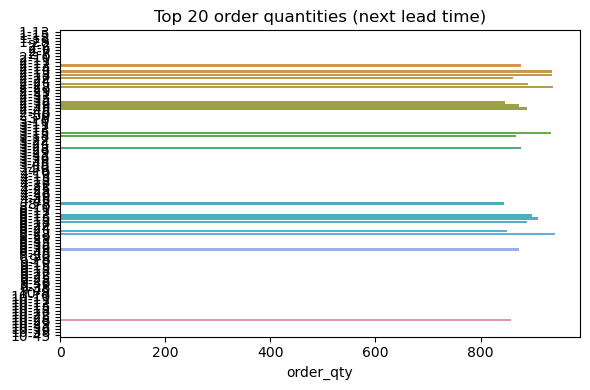

In [13]:
#Save artifacts (Parquet + metrics.json) and quick plots
# save
forecast.to_parquet(ART / "forecasts.parquet", index=False)
orders.to_parquet(ART / "orders.parquet", index=False)
with open(ART / "metrics.json","w") as f:
    json.dump(metrics, f, indent=2)

print("Wrote:", (ART / "forecasts.parquet").as_posix(),
               (ART / "orders.parquet").as_posix(),
               (ART / "metrics.json").as_posix())

# quick visuals
plt.figure(figsize=(6,4))
sns.barplot(data=orders.sort_values("order_qty", ascending=False).head(20),
            x="order_qty", y=orders["store"].astype(str)+"-"+orders["item"].astype(str))
plt.title("Top 20 order quantities (next lead time)")
plt.tight_layout()
plt.show()


In [14]:
# === Sanity check & show artifacts (metrics + sample rows) ===
from pathlib import Path
import json, pandas as pd
from IPython.display import display

ART = Path.home() / "Documents" / "demand-forecasting" / "artifacts"
print("Artifacts folder:", ART)
print("Exists:", ART.exists())

paths = {
    "metrics":   ART / "metrics.json",
    "forecasts": ART / "forecasts.parquet",
    "orders":    ART / "orders.parquet",
}

# Show which files are present
for name, p in paths.items():
    print(f"{name:>9}: {p} | exists={p.exists()}")

# Metrics
if paths["metrics"].exists():
    with open(paths["metrics"]) as f:
        metrics = json.load(f)
    print("\n--- Metrics ---")
    # Pretty print key/values
    for k, v in metrics.items():
        print(f"{k}: {v}")
else:
    print("\nNo metrics.json found.")

# Forecasts preview
if paths["forecasts"].exists():
    df_f = pd.read_parquet(paths["forecasts"])
    print(f"\n--- forecasts.parquet ---  shape={df_f.shape}")
    display(df_f.head(5))
else:
    print("\nNo forecasts.parquet found.")

# Orders preview + sanity
if paths["orders"].exists():
    df_o = pd.read_parquet(paths["orders"])
    print(f"\n--- orders.parquet ---  shape={df_o.shape}")
    display(df_o.head(5))
    assert (df_o["order_qty"] >= 0).all(), "Negative order quantities found!"
    print("Sanity OK: no negative order_qty.")
else:
    print("\nNo orders.parquet found.")


Artifacts folder: C:\Users\abhij\Documents\demand-forecasting\artifacts
Exists: True
  metrics: C:\Users\abhij\Documents\demand-forecasting\artifacts\metrics.json | exists=True
forecasts: C:\Users\abhij\Documents\demand-forecasting\artifacts\forecasts.parquet | exists=True
   orders: C:\Users\abhij\Documents\demand-forecasting\artifacts\orders.parquet | exists=True

--- Metrics ---
smape_lgb: 0.08796312553841067
smape_naive: nan
mase_lgb: 0.5459897716631127
mase_naive: nan
cutoff: 2017-11-19
horizon_days: 14

--- forecasts.parquet ---  shape=(1400, 4)


,date,store,item,sales
0,2017-11-19,1,13,77.451259
1,2017-11-19,1,13,80.657601
2,2017-11-19,1,13,84.172660
3,2017-11-19,1,13,88.075226
4,2017-11-19,1,13,97.255386



--- orders.parquet ---  shape=(100, 8)


,store,item,mu_lead,std_resid,sigma_lead,required_qty,on_hand,order_qty
0,1,13,634.811863,13.999905,37.040267,695.737681,0.0,696
1,1,15,665.097403,7.603499,20.116968,698.186871,0.0,699
2,1,18,623.441471,8.382042,22.176798,659.919058,0.0,660
3,1,28,648.796202,13.568435,35.898705,707.844318,0.0,708
4,2,2,612.912294,9.420175,24.923441,653.907707,0.0,654


Sanity OK: no negative order_qty.
